# Bethe Formalism

The Bethe stopping power formula, for nonrelativistic charged particles, is typically given by [1, p. 134]:
$$-\frac{dE}{d \ell}  = \frac{4 \pi N Z^2}{m_e v^2}\left(\frac{q_e^2}{4 \pi \epsilon_0}\right)^2 \left[ \ln \left( \frac{2 m_e v^2}{I}\right)\right],$$
where $q_e$ is the elementary charge, $Z$ is the charge of the incident particle, $m_e$ is the electron mass, $v$ is the velocity of the incident particle, $N$ is the number density of electrons in the target material, and $I$ is the mean excitation potential of the target material. We consider $\ell$ to be the path length of the incident particle through the target material, and $E$ to be the kinetic energy of the incident particle. The stopping power is defined to be precisely $- dE/d \ell$, and is a measure of the energy loss of the incident particle per unit path length through the target material. This is a statistical consequence of quantum mechanics, and is therefore an approximation of the energy loss of the incident particle; nonetheless, we can treat stopping power classically and obtain strong correspondence with actual results. Indeed, if one substitutes the classical expression for the kinetic energy of a particle, $$\frac{2 E}{m} = v^2,$$ into the Bethe formula, one obtains:
$$-\frac{dE}{d \ell}  = \frac{4\pi {q_e}^4 Z^2}{m_e v^2} N \ln\left(\frac{4 m_e E}{I}\right)$$
which is a purely classical expression for the stopping power of a charged particle in a target material. One can further simplify this by defining a stopping power per $Z^2$ as
$$S= -\frac{1}{Z^2}\frac{dE}{d \ell}$$
and a reduced energy per ion unit mass
$$\varepsilon = \frac{E}{m},$$
which removes dependence on the incident particle's species. Doing so yields the function
$$S(\varepsilon) = \frac{2 \pi N}{\varepsilon m_e} \left(\frac{q_e^2}{4 \pi \epsilon_0}\right)^2 [\ln(4 \frac{m_e \varepsilon}{I})].$$
This will serve as a comparison point for our BCA simulation, along with experimentally measured values.

In [1]:
import numpy as np
import os
# Relevant physical constants in SI base
epsilon_0 = 8.854187817e-12 # Vacuum permittivity in F/m
q_e = 1.602176634e-19 # Elementary charge in C
m_e = 9.10938356e-31 # Electron mass in kg
N = 1.76e29*6 # Number density of electrons in diamond in electrons/m^3
# Conversion factor from J to keV
J_to_keV = 6.242e15
m_to_microns = 1e6
amu_to_kg = 1.66053906660e-27

# Ionization potential of diamond in eV
I = 81.0 * q_e # Convert from eV to J


def S(epsilon):
    # Convert epsilon from MeV/amu to J/kg
    epsilon = epsilon * 1e6 * q_e / amu_to_kg
    raw = (2 * np.pi * N / (epsilon * m_e) * (q_e**2 / (4 * np.pi * epsilon_0))**2 * np.log(4 * m_e * epsilon / I))
    # Convert from J/m to keV/micron
    return raw * J_to_keV / m_to_microns

# Simulation

Before we begin simulating, we need to point python to the location of the RustBCA folder and a folder to output our results to. These paths are set in the cell below, and should be updated to match your local file structure.

In [2]:
### Dependencies ###
# RustBCA (Including compilation)
# numpy, matplotlib
# tomlkit
# dask (for large energy loss files)
# pyarrow, pandas (dependencies of dask)
# Jupyter Notebook (for running this script)
###--------------###

# Clear output to keep notebook tidy
from IPython.display import clear_output

#############################################
## RustBCA Directory (Absolute path)       ##
###---------------------------------------###
rustbca_dir = "/Users/michaeldunn/Documents/Dev/2026/Thesis/RustBCA-Benchmarks/RustBCA"
###---------------------------------------###
## End RustBCA Directory                   ##
#############################################


#############################################
## Output Directory (Absolute path)        ##
###---------------------------------------###
output_dir = "/Users/michaeldunn/Documents/Dev/2026/Thesis/RustBCA-Benchmarks/Benchmarks/Combined Fig/Data"
###---------------------------------------###
## End Output Directory                    ##
#############################################

The following cells contain code for running simulations of helium, hydrogen, and lithium atoms on diamond surfaces using binary collision via RustBCA. The following collision geometry is used for all simulations:

<style>
/* Center + size */
img[alt="bca_geometry.png"],
img[alt="bcasetup.png"] {
  display: block;
  margin-left: auto;
  margin-right: auto;
  width: 15%;
  max-width: 500px;
  height: auto;
}

/* Theme-adapt (dark mode) for B/W diagrams */
@media (prefers-color-scheme: dark) {
  img[alt="bca_geometry.png"],
  img[alt="bcasetup.png"] {
    filter: invert(1) brightness(1.05) contrast(1.1);
  }
}

body.jp-mod-theme-dark img[alt="bca_geometry.png"],
body.jp-mod-theme-dark img[alt="bcasetup.png"],
body[data-jp-theme-light="false"] img[alt="bca_geometry.png"],
body[data-jp-theme-light="false"] img[alt="bcasetup.png"],
.vscode-dark img[alt="bca_geometry.png"],
.vscode-dark img[alt="bcasetup.png"] {
  filter: invert(1) brightness(1.05) contrast(1.1);
}
</style>

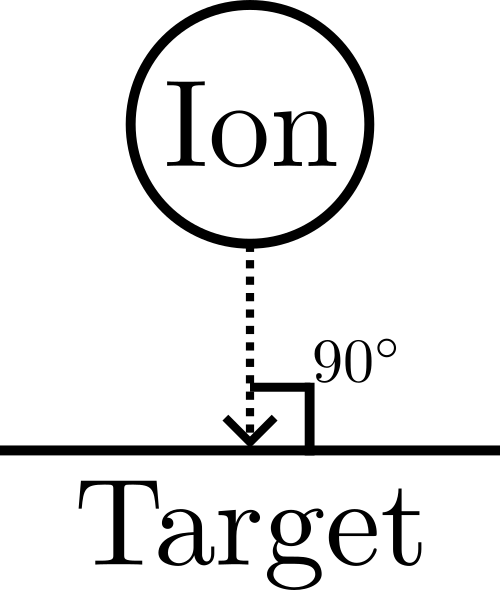

In [ ]:
### Dependencies ###
# RustBCA
# numpy, matplotlib
# tomlkit
# dask (for large energy loss files)
# pyarrow, pandas (dependencies of dask)
###--------------###


import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from libRustBCA import *



os.chdir(rustbca_dir)
# Grab materials and formulas from scripts directory
sys.path.append(os.getcwd()+'/scripts')



import materials as m
import time
from tomlkit import dumps

'''
This example simulates the implantation of various ions 
at a 0 degree angle into a C diamond target of arbitrary thickness.

It creates an input file as a nested dictionary which is written to
a TOML file using tomlkit.

It runs the input file with cargo run --release and reads the output files.
'''

run_sim = True
mode = '0D'
number_ions = 100 # higher energies allow smaller numbers of ions
angle = 0.1   # degrees; measured from surface normal

'''
For organizational purposes, species are commonly defined in dictionaries.
Additional examples can be found in scripts/materials.py, but values 
should be checked for correctness before use. Values are explained
in the relevant sections below.
'''

hydrogen = m.hydrogen
helium = m.helium
lithium = m.lithium

# Gong et. all parameters for Diamond
diamond = {
    'symbol': 'C',
    'name': 'carbon',
    'Z': 6.0,
    'm': 12.011, # AMU 
    'Es': 7.41, # eV
    'Ec': 0.1, # eV, reasonable for cutoff
    'Eb': 7.36, # eV
    'Ed': 52.0, # eV
    'n': 1.76e29, # 1/m^3, atomic density of diamond
}

options = {
    'name': 'input_file',
    'track_trajectories': False, # whether to track trajectories for plotting; memory intensive
    'track_recoils': False, # whether to track recoils; must enable for sputtering
    'track_recoil_trajectories': False, # whether to track recoil trajectories for plotting
    'track_displacements': False, # whether to track collisions with T > Ed for each species
    'track_energy_losses': True, # whether to track detailed collision energies; memory intensive -- do not disable here.
    'write_buffer_size': 2048, # how big the buffer is for file writing
    'weak_collision_order': 0, # weak collisions at radii (k + 1)*r; enable only when required
    'suppress_deep_recoils': False, # suppress recoils too deep to ever sputter
    'high_energy_free_flight_paths': False, # SRIM-style high energy free flight distances; use with caution
    'num_threads': os.cpu_count(), # number of threads to run in parallel
    'num_chunks': 100, # code will write to file every nth chunk; for very large simulations, increase num_chunks
    'electronic_stopping_mode': 'INTERPOLATED', # Previously 'LOW_ENERGY_NONLOCAL', leads to order of magnitude errors. Use 'INTERPOLATED' instead.
    'mean_free_path_model': 'LIQUID', # liquid is amorphous (constant mean free path); gas is exponentially-distributed mean free paths
    'interaction_potential': [['ZBL']], # ZBL potential chosen for all interactions
    'scattering_integral': [
        [
            {
                'GAUSS_MEHLER': {'n_points': 6}
            }
        ]
    ],

    'root_finder': [
        [
            {
                'NEWTON': {
                    'max_iterations': 100,
                    'tolerance': 1e-6
                }
            }
        ]
    ],
}

geometry_0D = {
    'length_unit': 'ANGSTROM',
    # used to correct nonlocal stopping for known compound discrpancies
    'electronic_stopping_correction_factor': 0.0,
    # number densities of each species
    'densities': [diamond["n"] / 1e30]
}

material_parameters = {
    'energy_unit': 'EV',
    'mass_unit': 'AMU',
    # bulk binding energy; typically zero as a model choice
    'Eb': [
        diamond["Eb"],
    ],
    # surface binding energy
    'Es': [
        diamond["Es"],    
        ],
    # cutoff energy - particles with E < Ec stop
    'Ec': [
        diamond["Ec"]
    ],
    # displacement energy - only used to track displacements
    'Ed': [
        diamond["Ed"]
        ],
    # atomic number
    'Z': [
        diamond["Z"]
    ],
    # atomic mass
    'm': [
        diamond["m"]
    ],
    # used to pick interaction potential from matrix in [options]
    'interaction_index': [0, 0],
    'surface_binding_model': {
        "PLANAR": {'calculation': "INDIVIDUAL"}
    },
    'bulk_binding_model': 'INDIVIDUAL'
}


## Hydrogen

In [4]:
#############################################
## Simulation Options                      ##
###---------------------------------------###
 # Hydrogen ion energies to simulate in MeV/amu
hydrogen_energies = np.arange(1.5, 6.1, 0.5)
 # Read range of energy deposition in Angstroms, and number of bins (e.g., numerical subdivisions of integral)
energy_read_range = np.linspace(0.0, 3e5, 10001)
###---------------------------------------###
## End Simulation Options                  ##
#############################################


# Convert hydrogen energies to raw energies in eV for input file
hydrogen_energies_in = hydrogen_energies * 1e6 * hydrogen["m"]

os.chdir(rustbca_dir)
stopping_data = [] # Collect stopping powers here in list

particle_parameters = {
    'length_unit': 'ANGSTROM',
    'energy_unit': 'EV',
    'mass_unit': 'AMU',
    # number of computational ions of this species to run at this energy
    'N': [number_ions],
    # atomic mass
    'm': [hydrogen["m"]],
    # atomic number
    'Z': [hydrogen["Z"]],
    # incidenet energy 
    'E': [0.0], # Changed in loop
    # cutoff energy - if E < Ec, particle stops
    'Ec': [hydrogen["Ec"]],
    # surface binding energy
    'Es': [hydrogen["Es"]],
    # initial position - if Es significant and E low, start (n)^(-1/3) above surface
    # otherwise 0, 0, 0 is fine; most geometry modes have surface at x=0 with target x>0
    'pos': [[0.0, 0.0, 0.0]],
    # initial direction unit vector; most geometry modes have x-axis into the surface
    'dir': [
        [
            np.cos(angle*np.pi/180.0),
            np.sin(angle*np.pi/180.0),
            0.0
        ]
        ],
    }

# Relevant constants

Z = hydrogen["Z"]
M = hydrogen["m"]


# Loop over incident energies
for incident_energy_mev_per_amu, incident_energy in zip(hydrogen_energies, hydrogen_energies_in):
    print(f'Running simulation for incident energy: {incident_energy_mev_per_amu} MeV/amu')
    particle_parameters['E'] = [incident_energy]
    input_data = {
        'options': options,
        'material_parameters': material_parameters,
        'particle_parameters': particle_parameters,
        'geometry_input': geometry_0D
    }

    # Attempt to cleanup line endings
    input_string = dumps(input_data).replace('\r', '')
    with  open('examples/input_file.toml', 'w') as input_file:
        input_file.write(input_string)

    if run_sim:
        os.system(f'cargo run --release {mode} examples/input_file.toml')

    # Read CSV in chunks to avoid memory issues
    loss_df = dd.read_csv('input_fileenergy_loss.output',
                    header=None,
                    dtype= float,
                    blocksize="64MB").dropna()
    
    # Process histogram in chunks without loading all data into memory
    depth_col = 4
    energy_cols = [2, 3]
    
    # Construct histogram for energy deposition function to measurement set by user
    bin_edges = energy_read_range
    hist = np.zeros(len(bin_edges) - 1)
    
    # Process in chunks
    for partition in loss_df.to_delayed():
        chunk = partition.compute()
        if len(chunk) > 0:
            depth = chunk.iloc[:, depth_col].values
            energy = chunk.iloc[:, energy_cols[0]].values + chunk.iloc[:, energy_cols[1]].values
            chunk_hist, _ = np.histogram(depth, bins=bin_edges, weights=energy)
            hist += chunk_hist
    
    loss = None  # Don't need full array anymore

    if hist.sum() == 0:
        print('No energy loss data')
    else:
        # Histogram energy loss data already computed above
        # Total x coordinate range is 0 to 300000 A with 10000 bins
        widths = np.diff(bin_edges)
        energy_density = np.divide(
            hist,
            widths * number_ions,
            out=np.zeros_like(hist, dtype=float),
            where=widths != 0
        )

    total_loss_per_ion = hist.sum() / number_ions

    # Print energy per ion in particular range (e.g., 0 to 1000 A)
    range_min = 0.0 # Depletion region
    range_max = 35000.0 #  End of target
    mask = (bin_edges[:-1] >= range_min) & (bin_edges[:-1] < range_max)
    energy_in_range = np.sum(energy_density[mask] * widths[mask])
    percent_loss_in_range = (energy_in_range / incident_energy) * 100.0
    stopping_power = energy_in_range / (range_max - range_min)
    # Convert to stopping power in KeV/um/Z**2 for comparison
    stopping_power_keV_per_um_per_Z2 = (stopping_power * 1e-3) / (1e-4) / (Z**2)
    # Convert energy to MeV/amu for comparison
    incident_energy_MeV_per_amu = incident_energy_mev_per_amu
    stopping_data.append({
        'Incident Energy (MeV/amu)': incident_energy_MeV_per_amu,
        'Stopping Power (KeV/um/Z^2)': stopping_power_keV_per_um_per_Z2,
        'Percent Energy Loss (%)': percent_loss_in_range
    })
    clear_output()

# Revert to script directory for output
os.chdir(output_dir)
# Write to file
stopping_powers_df = pd.DataFrame(stopping_data)
stopping_powers_df.to_csv('diamond_h_stopping_powers.csv', index=False)

print('Hydrogen ion simulation and data processing complete. Stopping powers saved.')

Running simulation for incident energy: 3.0 MeV/amu


    Finished `release` profile [optimized] target(s) in 0.11s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!


KeyboardInterrupt: 

## Helium

In [ ]:
#############################################
## Simulation Options                      ##
###---------------------------------------###
 # Helium ion energies to simulate in MeV/amu
helium_energies = np.arange(10.0, 30.0, 1.0)
 # Read range of energy deposition in Angstroms, and number of bins (e.g., numerical subdivisions of integral)
energy_read_range = np.linspace(0.0, 3e5, 10001)
###---------------------------------------###
## End Simulation Options                  ##
#############################################

# Convert helium energies to raw energies in eV for input file
helium_energies_in = helium_energies * 1e6 * helium["m"]

os.chdir(rustbca_dir)
stopping_data = [] # Collect stopping powers here in list

helium = m.helium

particle_parameters = {
    'length_unit': 'ANGSTROM',
    'energy_unit': 'EV',
    'mass_unit': 'AMU',
    # number of computational ions of this species to run at this energy
    'N': [number_ions],
    # atomic mass
    'm': [helium["m"]],
    # atomic number
    'Z': [helium["Z"]],
    # incidenet energy 
    'E': [0.0], # Changed in loop
    # cutoff energy - if E < Ec, particle stops
    'Ec': [helium["Ec"]],
    # surface binding energy
    'Es': [helium["Es"]],
    # initial position - if Es significant and E low, start (n)^(-1/3) above surface
    # otherwise 0, 0, 0 is fine; most geometry modes have surface at x=0 with target x>0
    'pos': [[0.0, 0.0, 0.0]],
    # initial direction unit vector; most geometry modes have x-axis into the surface
    'dir': [
        [
            np.cos(angle*np.pi/180.0),
            np.sin(angle*np.pi/180.0),
            0.0
        ]
        ],
    }

# Relevant constants
Z = helium["Z"]
M = helium["m"]

# Loop over incident energies
for incident_energy_mev_per_amu, incident_energy in zip(helium_energies, helium_energies_in):
    print(f'Running simulation for incident energy: {incident_energy_mev_per_amu} MeV/amu')
    particle_parameters['E'] = [incident_energy]
    input_data = {
        'options': options,
        'material_parameters': material_parameters,
        'particle_parameters': particle_parameters,
        'geometry_input': geometry_0D
    }

    # Attempt to cleanup line endings
    input_string = dumps(input_data).replace('\r', '')
    with  open('examples/input_file.toml', 'w') as input_file:
        input_file.write(input_string)

    if run_sim:
        os.system(f'cargo run --release {mode} examples/input_file.toml')

    # Read CSV in chunks to avoid memory issues
    loss_df = dd.read_csv('input_fileenergy_loss.output',
                    header=None,
                    dtype= float,
                    blocksize="64MB").dropna()
    
    # Process histogram in chunks without loading all data into memory
    depth_col = 4
    energy_cols = [2, 3]
    
    # Construct histogram for energy deposition function to measurement set by user
    bin_edges = energy_read_range
    hist = np.zeros(len(bin_edges) - 1)
    
    # Process in chunks
    for partition in loss_df.to_delayed():
        chunk = partition.compute()
        if len(chunk) > 0:
            depth = chunk.iloc[:, depth_col].values
            energy = chunk.iloc[:, energy_cols[0]].values + chunk.iloc[:, energy_cols[1]].values
            chunk_hist, _ = np.histogram(depth, bins=bin_edges, weights=energy)
            hist += chunk_hist
    
    loss = None  # Don't need full array anymore

    if hist.sum() == 0:
        print('No energy loss data')
    else:
        # Histogram energy loss data already computed above
        # Total x coordinate range is 0 to 300000 A with 10000 bins
        widths = np.diff(bin_edges)
        energy_density = np.divide(
            hist,
            widths * number_ions,
            out=np.zeros_like(hist, dtype=float),
            where=widths != 0
        )

    total_loss_per_ion = hist.sum() / number_ions

    print('Total energy loss per ion:', total_loss_per_ion, 'eV')

    # Print energy per ion in particular range (e.g., 0 to 1000 A)
    range_min = 0.0 # Depletion region
    range_max = 35000.0 #  End of target
    mask = (bin_edges[:-1] >= range_min) & (bin_edges[:-1] < range_max)
    energy_in_range = np.sum(energy_density[mask] * widths[mask])
    percent_loss_in_range = (energy_in_range / incident_energy) * 100.0
    stopping_power = energy_in_range / (range_max - range_min)
    print(f'Energy loss per ion in range {range_min} A to {range_max} A: {energy_in_range} eV ({percent_loss_in_range:.2f}%)')
    print(f'Stopping power in range {range_min} A to {range_max} A: {stopping_power} eV/A/ion')
    # Convert to stopping power in KeV/um/Z**2 for comparison
    stopping_power_keV_per_um_per_Z2 = (stopping_power * 1e-3) / (1e-4) / (Z**2)
    # Convert energy to MeV/amu for comparison
    incident_energy_MeV_per_amu = incident_energy_mev_per_amu
    stopping_data.append({
        'Incident Energy (MeV/amu)': incident_energy_MeV_per_amu,
        'Stopping Power (KeV/um/Z^2)': stopping_power_keV_per_um_per_Z2,
        'Percent Energy Loss (%)': percent_loss_in_range
    })
    clear_output()

# Revert to output directory for output
os.chdir(output_dir)

# Write to file
stopping_powers_df = pd.DataFrame(stopping_data)
stopping_powers_df.to_csv('diamond_he_stopping_powers.csv', index=False)

print('Helium ion simulation and data processing complete. Stopping powers saved.')

Running simulation for incident energy: 10.0 MeV/amu


    Finished `release` profile [optimized] target(s) in 0.15s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 1748734.449968571 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 200815.1988926194 eV (0.50%)
Stopping power in range 0.0 A to 35000.0 A: 5.737577111217697 eV/A/ion
Running simulation for incident energy: 11.0 MeV/amu


    Finished `release` profile [optimized] target(s) in 0.13s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Total energy loss per ion: 177510.81212419123 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 20442.005919808376 eV (0.05%)
Stopping power in range 0.0 A to 35000.0 A: 0.584057311994525 eV/A/ion
Running simulation for incident energy: 12.0 MeV/amu


    Finished `release` profile [optimized] target(s) in 0.13s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...


## Lithium

In [ ]:
#############################################
## Simulation Options                      ##
###---------------------------------------###
 # Lithium ion energies to simulate in MeV/amu
lithium_energies = np.arange(20.0, 31.0, 1.0)
 # Read range of energy deposition in Angstroms, and number of bins (e.g., numerical subdivisions of integral)
energy_read_range = np.linspace(0.0, 3e5, 10001)
###---------------------------------------###
## End Simulation Options                  ##
#############################################

# Convert lithium energies to raw energies in eV for input file
lithium_energies_in = lithium_energies * 1e6 * lithium["m"]

os.chdir(rustbca_dir)
stopping_data = [] # Collect stopping powers here in list

lithium = m.lithium

particle_parameters = {
    'length_unit': 'ANGSTROM',
    'energy_unit': 'EV',
    'mass_unit': 'AMU',
    # number of computational ions of this species to run at this energy
    'N': [number_ions],
    # atomic mass
    'm': [lithium["m"]],
    # atomic number
    'Z': [lithium["Z"]],
    # incidenet energy 
    'E': [0.0], # Changed in loop
    # cutoff energy - if E < Ec, particle stops
    'Ec': [lithium["Ec"]],
    # surface binding energy
    'Es': [lithium["Es"]],
    # initial position - if Es significant and E low, start (n)^(-1/3) above surface
    # otherwise 0, 0, 0 is fine; most geometry modes have surface at x=0 with target x>0
    'pos': [[0.0, 0.0, 0.0]],
    # initial direction unit vector; most geometry modes have x-axis into the surface
    'dir': [
        [
            np.cos(angle*np.pi/180.0),
            np.sin(angle*np.pi/180.0),
            0.0
        ]
        ],
    }

# Relevant constants
Z = lithium["Z"]
M = lithium["m"]

# Loop over incident energies
for incident_energy_mev_per_amu, incident_energy in zip(lithium_energies, lithium_energies_in):
    print(f'Running simulation for incident energy: {incident_energy_mev_per_amu} MeV/amu')
    particle_parameters['E'] = [incident_energy]
    input_data = { 
        'options': options,
        'material_parameters': material_parameters,
        'particle_parameters': particle_parameters,
        'geometry_input': geometry_0D
    }

    # Attempt to cleanup line endings
    input_string = dumps(input_data).replace('\r', '')
    with  open('examples/input_file.toml', 'w') as input_file:
        input_file.write(input_string)

    if run_sim:
        os.system(f'cargo run --release {mode} examples/input_file.toml')

    # Read CSV in chunks to avoid memory issues
    loss_df = dd.read_csv('input_fileenergy_loss.output',
                    header=None,
                    dtype= float,
                    blocksize="64MB").dropna()
    
    # Process histogram in chunks without loading all data into memory
    depth_col = 4
    energy_cols = [2, 3]
    
    # Construct histogram for energy deposition function to measurement set by user
    bin_edges = energy_read_range
    hist = np.zeros(len(bin_edges) - 1)
    
    # Process in chunks
    for partition in loss_df.to_delayed():
        chunk = partition.compute()
        if len(chunk) > 0:
            depth = chunk.iloc[:, depth_col].values
            energy = chunk.iloc[:, energy_cols[0]].values + chunk.iloc[:, energy_cols[1]].values
            chunk_hist, _ = np.histogram(depth, bins=bin_edges, weights=energy)
            hist += chunk_hist
    
    loss = None  # Don't need full array anymore

    if hist.sum() == 0:
        print('No energy loss data')
    else:
        # Histogram energy loss data already computed above
        # Total x coordinate range is 0 to 300000 A with 10000 bins
        widths = np.diff(bin_edges)
        energy_density = np.divide(
            hist,
            widths * number_ions,
            out=np.zeros_like(hist, dtype=float),
            where=widths != 0
        )

    total_loss_per_ion = hist.sum() / number_ions

    print('Total energy loss per ion:', total_loss_per_ion, 'eV')

    # Print energy per ion in particular range (e.g., 0 to 1000 A)
    range_min = 0.0 # Depletion region
    range_max = 35000.0 #  End of target
    mask = (bin_edges[:-1] >= range_min) & (bin_edges[:-1] < range_max)
    energy_in_range = np.sum(energy_density[mask] * widths[mask])
    percent_loss_in_range = (energy_in_range / incident_energy) * 100.0
    stopping_power = energy_in_range / (range_max - range_min)
    print(f'Energy loss per ion in range {range_min} A to {range_max} A: {energy_in_range} eV ({percent_loss_in_range:.2f}%)')
    print(f'Stopping power in range {range_min} A to {range_max} A: {stopping_power} eV/A/ion')
    # Convert to stopping power in KeV/um/Z**2 for comparison
    stopping_power_keV_per_um_per_Z2 = (stopping_power * 1e-3) / (1e-4) / (Z**2)
    # Convert energy to MeV/amu for comparison
    incident_energy_MeV_per_amu = incident_energy_mev_per_amu
    stopping_data.append({
        'Incident Energy (MeV/amu)': incident_energy_MeV_per_amu,
        'Stopping Power (KeV/um/Z^2)': stopping_power_keV_per_um_per_Z2,
        'Percent Energy Loss (%)': percent_loss_in_range
    })
    clear_output()

# Revert to output directory for output
os.chdir(output_dir)

# Write to file
stopping_powers_df = pd.DataFrame(stopping_data)
stopping_powers_df.to_csv('diamond_li_stopping_powers.csv', index=False)
print('Lithium ion simulation and data processing complete. Stopping powers saved.')

Running simulation for incident energy: 20000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.13s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 12806589.509847958 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 1171237.4879509213 eV (5.86%)
Stopping power in range 0.0 A to 35000.0 A: 33.46392822716918 eV/A/ion
Running simulation for incident energy: 21000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.11s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 12000841.2930202 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 1130011.998248974 eV (5.38%)
Stopping power in range 0.0 A to 35000.0 A: 32.28605709282783 eV/A/ion
Running simulation for incident energy: 22000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.13s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 11337089.034799255 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 1091276.904355215 eV (4.96%)
Stopping power in range 0.0 A to 35000.0 A: 31.179340124434713 eV/A/ion
Running simulation for incident energy: 23000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.12s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 10749828.335853502 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 1055835.1130366486 eV (4.59%)
Stopping power in range 0.0 A to 35000.0 A: 30.166717515332817 eV/A/ion
Running simulation for incident energy: 24000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.12s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 10248948.316350447 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 1023186.356528989 eV (4.26%)
Stopping power in range 0.0 A to 35000.0 A: 29.23389590082826 eV/A/ion
Running simulation for incident energy: 25000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.13s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 9805308.20336172 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 991929.2552379267 eV (3.97%)
Stopping power in range 0.0 A to 35000.0 A: 28.340835863940764 eV/A/ion
Running simulation for incident energy: 26000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.14s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 9408159.943932831 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 962580.2823142118 eV (3.70%)
Stopping power in range 0.0 A to 35000.0 A: 27.502293780406053 eV/A/ion
Running simulation for incident energy: 27000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.14s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 9052151.536107764 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 935436.7108079125 eV (3.46%)
Stopping power in range 0.0 A to 35000.0 A: 26.72676316594036 eV/A/ion
Running simulation for incident energy: 28000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.14s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 8730491.010769421 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 909972.4461867402 eV (3.25%)
Stopping power in range 0.0 A to 35000.0 A: 25.999212748192576 eV/A/ion
Running simulation for incident energy: 29000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.13s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 8431948.056560442 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 886240.3693104261 eV (3.06%)
Stopping power in range 0.0 A to 35000.0 A: 25.321153408869318 eV/A/ion
Running simulation for incident energy: 30000000.0 eV


    Finished `release` profile [optimized] target(s) in 0.13s
     Running `target/release/RustBCA 0D examples/input_file.toml`


Processing 100 ions...
Initializing with 10 threads...
Finished!
Total energy loss per ion: 8159148.033519524 eV
Energy loss per ion in range 0.0 A to 35000.0 A: 863438.0915517404 eV (2.88%)
Stopping power in range 0.0 A to 35000.0 A: 24.669659758621155 eV/A/ion


# Plots

Next, we compare our obtained simulation with the Bethe stopping power formula, as well as with experimentally measured values. The following plot shows the stopping power per $Z^2$ for helium, hydrogen, and lithium atoms incident on diamond surfaces, along with the Bethe stopping power function. Experimental values are taken from [2] and [3].

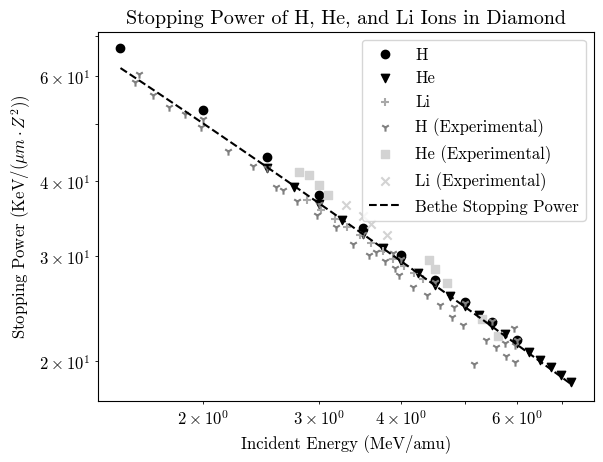

In [8]:
# Now, we have three CSV files with stopping powers for H, He, and Li ions in diamond. We can read these files and plot the stopping power as a function of incident energy for each ion species.
import pandas as pd
import matplotlib.pyplot as plt

### Visual Settings ###
# Set the font family to 'serif' and the serif font to 'cmr10' (Computer Modern Roman)
plt.rcParams['font.family'], plt.rcParams['font.serif'] = 'serif', ['cmr10']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['axes.formatter.use_mathtext'] = True

# Change to data directory
os.chdir(output_dir)
# Read the CSV files
h_data = pd.read_csv('diamond_h_stopping_powers.csv')
he_data = pd.read_csv('diamond_he_stopping_powers.csv')
li_data = pd.read_csv('diamond_li_stopping_powers.csv')
# Read experimental data from literature
experimental_data = pd.read_csv('experimental_stopping_powers.csv')  # Replace with actual file path
# Separate species in experimental data
experimental_h = experimental_data[experimental_data['Species'] == 'H']
experimental_he = experimental_data[experimental_data['Species'] == 'He']
experimental_li = experimental_data[experimental_data['Species'] == 'Li']
# Plotting
plt.scatter(h_data['Incident Energy (MeV/amu)'], h_data['Stopping Power (KeV/um/Z^2)'], label='H', marker='o', color = 'black') # Change shapes for better visibility
# Imagine what it looks like in black and white
plt.scatter(he_data['Incident Energy (MeV/amu)'], he_data['Stopping Power (KeV/um/Z^2)'], label='He', marker='v', color = 'black')
plt.scatter(li_data['Incident Energy (MeV/amu)'], li_data['Stopping Power (KeV/um/Z^2)'], label='Li', marker='+', color = 'darkgray')
plt.scatter(experimental_h['Energy (MeV/amu)'], experimental_h['Stopping Power (keV/um)'], label='H (Experimental)', marker='1', color = 'gray')
plt.scatter(experimental_he['Energy (MeV/amu)'], experimental_he['Stopping Power (keV/um)'], label='He (Experimental)', marker='s', color = 'lightgray')
plt.scatter(experimental_li['Energy (MeV/amu)'], experimental_li['Stopping Power (keV/um)'], label='Li (Experimental)', marker='x', color = 'lightgray')
plt.xlabel('Incident Energy (MeV/amu)')
plt.ylabel('Stopping Power (KeV/$(\mu m \cdot Z^2)$)')
plt.title('Stopping Power of H, He, and Li Ions in Diamond')
plt.loglog()  # Use logarithmic scale for better visibility
# Plot the Bethe stopping power using our previously defined function S(epsilon), on the same graph for comparison
incident_energies = np.linspace(np.min(h_data['Incident Energy (MeV/amu)']), np.max(he_data['Incident Energy (MeV/amu)']), 100)
function_data = S(incident_energies)
plt.plot(incident_energies, function_data, label='Bethe Stopping Power', linestyle='--', color = 'black')
plt.legend()
plt.savefig('diamond_stopping_powers.pdf', format='pdf', bbox_inches='tight')
plt.show()

# References

[1] Peter Sigmund, _Particle Penetration and Radiation Effects: General Aspects and Stopping of Swift Point Charges_, 1st ed. 2006. (Springer Berlin Heidelberg, Berlin, Heidelberg, 2006).

[2] A. Crnjac, M. Jakšić, M. Matijević, M. Rodriguez-Ramos, M. Pomorski, and Z. Siketić, Energy loss of MeV protons in diamond: Stopping power and mean ionization energy, _Diamond and Related Materials_ **132**, 109621 (2023).

[3] R. W. Fearick and J. P. F. Sellschop, Energy loss of light ions in diamond, _Nuclear Instruments and Methods_ **168**, 51 (1980).
